In [1]:
# Try to use the solution at:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3079956/

In [1]:
import numpy as np
from scipy.special import ellipe, ellipk, ellipeinc
%matplotlib inline
import matplotlib.pylab as plt

In [3]:
# try to iteratively solve for m

def k_m(m, n):
    """
    Parameters
    ----------
    m : float
        The value to iterate
    n : int
        The number of points on the sphere
    """
    numerator = m*np.pi*n
    numerator *= (2.*ellipe(-m**2) - ellipk(-m**2))
    denom = n*np.pi*ellipe(-m**2)
    denom -= n*np.pi*ellipk(-m**2)
    denom += m*ellipe(-m**2)**2
    result = numerator/denom
    return result

In [4]:
# So, I should wrap all this up with a tolerance kwarg
n = 20.
# Let's try to iterate this thing
m_old = np.sqrt(n*np.pi)
ms = [m_old]
for i in range(10):
    ms.append(k_m(ms[-1], n))
    

In [5]:
def S_length(theta, m):
    """
    Where theta is an array
    """
    case1 = np.where((theta > np.pi/2.) & (theta <= np.pi))
    case2 = np.where((theta >= 0.) & (theta <= np.pi/2.))
    
    result = theta*0
    result[case1] = 2.*ellipe(-m**2) - ellipeinc(np.pi-theta[case1] , -m**2)
    result[case2] = ellipeinc(theta[case2], -m**2)
    return result

In [6]:
def k_theta(theta, m):
    """
    Parameters
    """
    # I could make this a class and make j just once
    j = np.arange(theta.size)+1
    result = theta+0
    numerator = (2.*j-1)*np.pi - m*S_length(theta, m)
    denom = m*np.sqrt(1.+m**2*np.sin(theta)**2)
    result += numerator/denom
    # Make sure we don't wrap around in crazy ways
    result = result % (np.pi)
    return result


In [7]:
j = np.arange(n)+1
theta_init = np.arccos(1.-(2*j-1)/n)

In [8]:
theta = theta_init
for i in range(10):
    theta = k_theta(theta, ms[-1])

In [9]:
phi = ms[-1]*theta % (2.*np.pi)  # phi is longitude (or RA). z=cos(theta). so dec = pi/2 - theta

In [10]:
def theta2dec(theta):
    dec = np.pi/2. - theta
    return dec

In [11]:
theta - k_theta(theta, ms[-1])

array([  0.00000000e+00,   0.00000000e+00,  -1.11022302e-16,
         1.11022302e-16,   0.00000000e+00,   2.22044605e-16,
         2.22044605e-16,  -4.44089210e-16,   2.22044605e-16,
         2.22044605e-16,  -2.22044605e-16,   2.22044605e-16,
         0.00000000e+00,   0.00000000e+00,   4.44089210e-16,
         4.44089210e-16,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   8.88178420e-16])

In [12]:
dec = theta2dec(theta)

In [13]:
dec

array([ 1.30347023,  1.04858044,  0.87258193,  0.726781  ,  0.59749671,
        0.47853012,  0.36639067,  0.25882034,  0.15419281,  0.05121951,
       -0.05121951, -0.15419281, -0.25882034, -0.36639067, -0.47853012,
       -0.59749671, -0.726781  , -0.87258193, -1.04858044, -1.30347023])

In [14]:
phi

array([ 2.08555975,  4.074097  ,  5.44715941,  0.30144839,  1.31006713,
        2.23819182,  3.11305407,  3.95227013,  4.76852782,  5.57187988,
        0.08787839,  0.89123046,  1.70748815,  2.54670421,  3.42156646,
        4.34969115,  5.35830989,  0.21259887,  1.58566128,  3.57419853])

In [8]:
# let's wrap it up in a class
class make_spiral(object):
    """
    Find a solution for drawing a spiral of evenly spaced points on a sphere.
    
    Based on: 
    Koay, Cheng Guan. “Analytically Exact Spiral Scheme for 
    Generating Uniformly Distributed Points on the Unit Sphere.” 
    Journal of computational science 2.1 (2011): 88–91. PMC. Web. 1 June 2018.
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3079956/
    """
    def __init__(self, n, ttol=1e-10, niter=20):
        self.n = n
        self.j = np.arange(n) + 1
        # Initial guess
        self.m = np.sqrt(n*np.pi)
        
        # iterate to solve for m
        for i in range(niter):
            m_old = self.m + 0
            self.m = self.k_m(self.m)
        # if we haven't reached specified tolerance
        while np.abs(m_old-self.m) > ttol:
            m_old = self.m + 0
            self.m = self.k_m(self.m)
            
        theta = np.arccos(1.-(2*self.j-1)/self.n)
        for i in range(niter):
            theta_old = theta + 0
            theta = self.k_theta(theta)
        while np.max(np.abs(theta-theta_old)) > ttol:
            theta_old = theta + 0
            theta = self.k_theta(theta)
            
        self.theta = theta
        
    def __call__(self):
        
        ra = self.m*self.theta % (2.*np.pi)
        dec = np.pi/2. - self.theta
        return ra, dec
        
    def k_m(self, m):
        """
        Appendix A
        
        Parameters
        ----------
        m : float
            The value to iterate
        """
        numerator = m*np.pi*self.n
        numerator *= (2.*ellipe(-m**2) - ellipk(-m**2))
        denom = self.n*np.pi*ellipe(-m**2)
        denom -= self.n*np.pi*ellipk(-m**2)
        denom += m*ellipe(-m**2)**2
        result = numerator/denom
        return result
    
    def S_length(self, theta):
        """
        Where theta is an array
        """
        case1 = np.where((theta > np.pi/2.) & (theta <= np.pi))
        case2 = np.where((theta >= 0.) & (theta <= np.pi/2.))

        result = theta*0
        result[case1] = 2.*ellipe(-self.m**2) - ellipeinc(np.pi-theta[case1] , -self.m**2)
        result[case2] = ellipeinc(theta[case2], -self.m**2)
        return result
    
    def k_theta(self, theta):
        """
        Parameters
        """
        result = theta+0
        numerator = (2.*self.j-1)*np.pi - self.m*self.S_length(theta)
        denom = self.m*np.sqrt(1.+self.m**2*np.sin(theta)**2)
        result += numerator/denom
        # Make sure we don't wrap around in crazy ways
        result = result % (np.pi)
        return result
    
    

In [13]:
spiral = make_spiral(1000)

In [14]:
ra, dec = spiral()

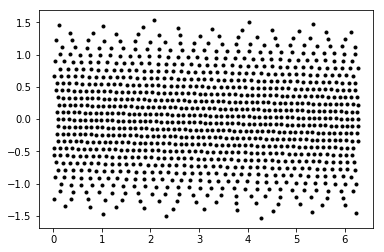

In [15]:
plt.plot(ra, dec, 'k.')

In [16]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [34]:
bundleList = []

metric = metrics.CountMetric(col='ra')
slicer = slicers.HealpixSlicer(lonCol='ra', latCol='dec', nside=512)
sql = ''

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [35]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
conn = None
bg = metricBundles.MetricBundleGroup(bd, conn)

/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:107: UserWarning: Warning: dbObj should be an instantiated Database (or child) object.
  warnings.warn('Warning: dbObj should be an instantiated Database (or child) object.')


In [48]:
spiral = make_spiral(5200)
ra, dec = spiral()
names =['ra', 'dec']
types = [float, float]
data = np.zeros(ra.size, dtype = list(zip(names, types)))
data['ra'] = np.degrees(ra)
data['dec'] = np.degrees(dec)


In [49]:
bg.setCurrent('')
bg.runCurrent('', simData=data)

Running:  ['opsim_Count_ra_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 1.2277  dipole: lon: -20.0253, lat: -6.05823, amp: 0.0005368
Plotting complete.


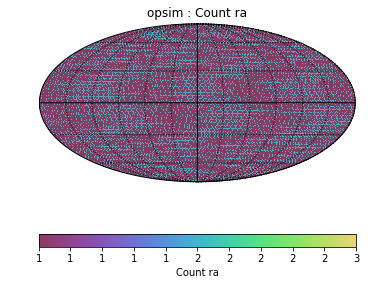

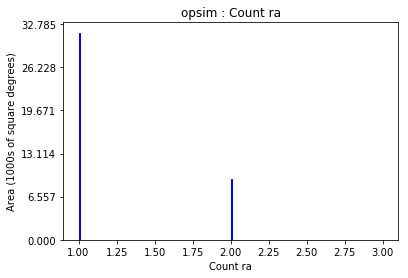

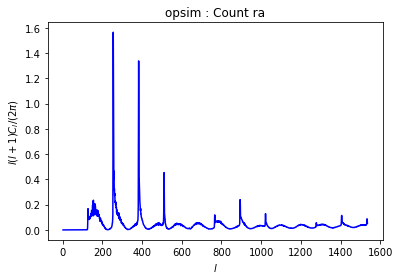

In [50]:
bg.plotAll(closefigs=False)